In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

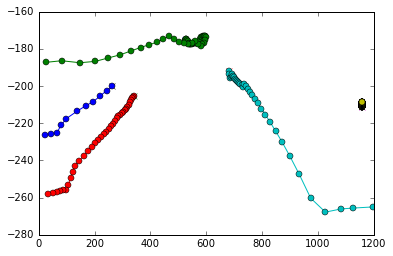

In [3]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [4]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [5]:
np.random.seed(7)

In [6]:
def buildLookbackDataset(tracks, lookback=3):
    lookback +=1
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [7]:
# Ignore for now
# dset = np.zeros((25002,8))
# for i in xrange(25002):
#     dset[i,:] = dataset[i]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16751, 8251)


In [10]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [11]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [12]:
xtrain[0].shape


(3, 2)

In [73]:
import os
os.environ["THEANO_FLAGS"] = 'optimizer=None,exception_verbosity=high'
import theano
reload(theano)
import theano.tensor as T
from theano import printing
from theano.tensor.nlinalg import Det

In [101]:
def custom_objective(y_true, y_pred):
    pred = y_pred[:,0:2].reshape((2,1))
    cov = y_pred[:,2:6].reshape((2,2))
    mu = y_true[:,0:2].reshape((2,1))
    diff = pred - mu
    dot1 = T.dot(diff.T, T.inv(abs(cov)))
    dot2 = T.dot(dot1, diff)
    tmp = -(dot2)/2
    prob = T.exp(tmp)
    det = Det()
    prob = prob / T.sqr(det(2* np.pi * cov))
    ret = -T.log(prob)
    return prob

In [103]:
model = Sequential()
model.add(LSTM(4, input_shape=(3,2)))
model.add(Dense(6))
model.compile(loss=custom_objective, optimizer='adam')
model.fit(xtrain, ytrain, nb_epoch=5, batch_size=1, verbose=2)

Epoch 1/5
22s - loss: 3.2130e-06
Epoch 2/5
22s - loss: 6.8138e-04
Epoch 3/5
21s - loss: 5.0410e-05
Epoch 4/5
23s - loss: 6.6326e-09
Epoch 5/5
21s - loss: 1.6236e-12


In [104]:
print xtrain[0]
print trainPredict[0]

[[ 0.62446123  0.09930999]
 [ 0.62646688  0.09784558]
 [ 0.62939047  0.09337126]]
[  0.44203278   0.38716668  -3.53306556  29.82113838 -25.98446465
  -2.94223571]


In [105]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
print trainPredict.shape
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

(16751, 6)


ValueError: y_true and y_pred have different number of output (2!=6)

In [63]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,0:2], scaledPredictTrain[:,2:4]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,0:2], scaledPredictTest[:,2:4]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

Train Score: 5.0506726 RMSE
Test Score: 4.9097064 RMSE
(16751, 2)


In [18]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[777.654416, 165.681078]
[781.156791, 165.186175]


In [19]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416   165.681078   781.156791   165.186175   784.809185
   164.670002   788.6214485  164.131158 ]]
[[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126
   0.63313688  0.09231694]]


In [20]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [21]:
predictedTracks = rebuildTracks(tracks,model)

In [22]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


Training
161 of 579


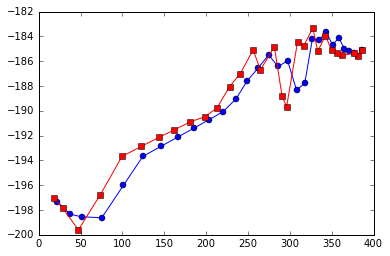

In [64]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [49]:
def covariance(tracks, predTracks):
    x = []
    y = []
    for (key, track) in tracks.items():
        for j, point in enumerate(track):
            x.append(point[0] - predictedTracks[key][j][0])
            y.append(point[1] - predictedTracks[key][j][1])
    x = np.matrix(x)
    y = np.matrix(y)
    m = np.concatenate((x,y), axis=0)
    print np.var(x)
    print np.var(y)
    return np.cov(m)

In [50]:
print covariance(tracks, predictedTracks)

28.0064938099
2.72131484714
[[ 28.00751973  -0.93562177]
 [ -0.93562177   2.72141453]]
